In [1]:
import pandas as pd

df_positive = pd.read_csv('positive.tsv', sep='\t')
df_negative = pd.read_csv('augmented_negative.tsv', sep='\t')
df_neutral = pd.read_csv('augmented_neutral.tsv', sep='\t')

df = df_positive.append(df_negative, ignore_index=True)
df = df.append(df_neutral, ignore_index=True)

C:\Users\B\AppData\Local\Temp\ipykernel_13308\2881387631.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_positive.append(df_negative, ignore_index=True)
C:\Users\B\AppData\Local\Temp\ipykernel_13308\2881387631.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_neutral, ignore_index=True)


In [5]:
df = df.sample(frac = 1)
df.head()

,text,label
18898,"Kami memiliki Chef, playset Happy Kitchen, dan...",neutral
2129,"batagor nya enak , mi yakin nya enak . ada ane...",positive
16746,"di usia 57 tahun , saat nya gerakan pramuka di...",neutral
22090,jumlah pemilih nasional 185.379.878 dan pemili...,neutral
12060,"interior restorannya sangat bagus, cocok untuk...",negative


In [6]:
df.shape

(23629, 2)

In [7]:
df.label.value_counts()

neutral     8202
negative    8068
positive    7359
Name: label, dtype: int64

In [8]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

def cleansing(text):

    # Lower Case Operation
    text = text.lower()

    # Removing Unnecessary Characters
    text = re.sub('\n', ' ', text)
    text = re.sub('rt', ' ', text)
    text = re.sub('user', ' ', text)
    text = re.sub(r'((www\.[^\s]+)|(http?://[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub(' +', ' ', text)

    # Removing Non-Alphanumeric Characters
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)

    # Normalizing Alay Words
    text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

    # Removing Stopword
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = text.strip()

    # Stemming
    text = stemmer.stem(text)

    return text

In [9]:
df['text_clean'] = df.text.apply(cleansing)

In [10]:
df.head()

,text,label,text_clean
18898,"Kami memiliki Chef, playset Happy Kitchen, dan...",neutral,milik chef playset happy dapur main masak warn...
2129,"batagor nya enak , mi yakin nya enak . ada ane...",positive,batagor nya enak mi nya enak aneka makan cicip...
16746,"di usia 57 tahun , saat nya gerakan pramuka di...",neutral,usia 57 nya gera pramuka tanah air tantang zam...
22090,jumlah pemilih nasional 185.379.878 dan pemili...,neutral,pilih nasional 185 379 878 pilih asing 1 281 597
12060,"interior restorannya sangat bagus, cocok untuk...",negative,interior restoran bagus cocok kumpul teman sem...


In [11]:
data_preprocessed = df.text_clean.tolist()
data_preprocessed[0:5]

['milik chef playset happy dapur main masak warna merah muda stand budiwastono',
 'batagor nya enak mi nya enak aneka makan cicip toko nya renovasi bagus musala area khas bandung nya pilih sayang area parkir parkir panjang jalan repot hujan',
 'usia 57 nya gera pramuka tanah air tantang zaman anggota pramuka didik bahasa morse tahu digital sepe i coding a ificial intelligence advance robotic internet of pikir',
 'pilih nasional 185 379 878 pilih asing 1 281 597',
 'interior restoran bagus cocok kumpul teman sempit skala restoran sibuk tunggu selesai makan istimewa oreo pancake nasi goreng banana split']

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data_preprocessed)

X = tfidf_vect.transform(data_preprocessed)
print ("Feature Extraction Berhasil!")

Feature Extraction Berhasil!


In [13]:
X.shape

(23629, 15178)

In [14]:
import pickle

pickle.dump(tfidf_vect, open("nn_aug_tfidf.feature", "wb"))

In [15]:
from sklearn.model_selection import train_test_split

classes = df.label
X_train, X_test, y_train, y_test = train_test_split(X, classes, shuffle=False, stratify=None, test_size = 0.2)

In [16]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [17]:
model.fit(X_train, y_train)
pickle.dump(model, open("nn_aug_tfidf.model", "wb"))

print ("Training Berhasil!")

Training Berhasil!


In [18]:
from sklearn.metrics import classification_report

test = model.predict(X_test)

print ("Testing Selesai!")

print(classification_report(y_test, test))

Testing Selesai!
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      1570
     neutral       0.93      0.96      0.95      1626
    positive       0.89      0.83      0.86      1530

    accuracy                           0.89      4726
   macro avg       0.89      0.89      0.89      4726
weighted avg       0.89      0.89      0.89      4726



C:\Users\B\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


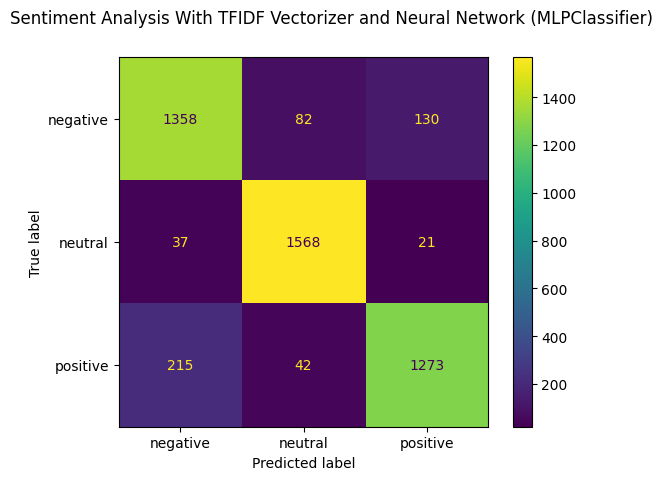

In [20]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig = plot_confusion_matrix(model, X_test, y_test, display_labels=model.classes_)
fig.figure_.suptitle("Sentiment Analysis With TFIDF Vectorizer and Neural Network (MLPClassifier)")
plt.show()